In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer

from tqdm import tqdm

dataset = 'Cora'
path = osp.join('data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.linear = torch.nn.Linear(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.embed(x, edge_index)
        x = self.linear(x)
        return F.log_softmax(x, dim=1)
    
    def embed(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        return x


device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

pbar = tqdm(range(1000))
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pbar.set_description("Loss -> %.5f" % loss.item())
model.eval()

Loss -> 0.02824: 100%|██████████| 1000/1000 [00:22<00:00, 43.87it/s]


Net(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 16)
  (linear): Linear(in_features=16, out_features=7, bias=True)
)

In [2]:
with torch.no_grad():
    preds = model(x, edge_index)

In [3]:
import seaborn as sns
import pyro
import pyro.distributions as dist
from torch_geometric.utils import k_hop_subgraph, to_networkx
import torch.distributions.constraints as constraints
from torch_geometric.data import Data
import networkx as nx
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

with torch.no_grad():
    embeddings = model.embed(x, edge_index)

in_dim = 3*embeddings.size(1)
hidden_dim = 60
out_dim = 2
    
seq = torch.nn.Sequential(torch.nn.Linear(in_dim, hidden_dim),
                          torch.nn.LeakyReLU(),
                          torch.nn.Linear(hidden_dim, hidden_dim),
                          torch.nn.LeakyReLU(),
                          torch.nn.Linear(hidden_dim, out_dim)).to(device)
    
def sample_model(X, y, edge_index, node_idx, mapping):
    in_dim = 3*embeddings.size(1)
    hidden_dim = 64
    out_dim = 2
    
    #fc_mean1 = torch.zeros([hidden_dim, in_dim]).to(device)
    #bias_mean1 = torch.zeros(hidden_dim).to(device)
    #fc1 = pyro.sample("fc1", dist.Normal(fc_mean1, 1).to_event(2))
    #bias1 = pyro.sample("bias1", dist.Normal(bias_mean1, 1).to_event(1))
    
    inp = torch.cat([embeddings[edge_index[0, :], :], embeddings[edge_index[1, :], :], 
                     embeddings[torch.repeat_interleave(torch.tensor(node_idx), edge_index.size(1)), :]], dim = -1)
    #h = (fc1 @ inp.T).T + bias1
    #h = F.leaky_relu(h)
    
    #fc_mean2 = torch.zeros([out_dim, hidden_dim]).to(device)
    #bias_mean2 = torch.zeros(out_dim).to(device)
    #fc2 = pyro.sample("fc2", dist.Normal(fc_mean2, 1).to_event(2))
    #bias2 = pyro.sample("bias2", dist.Normal(bias_mean2, 1).to_event(1))
    
    #h = torch.abs((fc2 @ h.T).T + bias2).sigmoid().clamp(min=1e-5)
    h = torch.abs(seq(inp)).clamp(min=1e-5)
    
    f = pyro.sample("latent_f", dist.Beta(h[:, 0], h[:, 1]).to_event(1))
    m = pyro.sample("mask", dist.Bernoulli(f).to_event(1))
    mean = model(X, edge_index[:, m == 1])[mapping].reshape(-1)
    sigma = (0.0000000001 * torch.eye(mean.size(0))).to(device)
    y_sample = pyro.sample("y", dist.MultivariateNormal(mean, sigma), obs = y)

In [4]:
def sample_guide(X, y, edge_index, node_idx, mapping):
    in_dim = 3*embeddings.size(1)
    hidden_dim = 64
    out_dim = 2
    
    #fc_mean1 = torch.zeros([hidden_dim, in_dim]).to(device)
    #bias_mean1 = torch.zeros(hidden_dim).to(device)
    #fc_mean1_q = pyro.param("fc_mean1_q", fc_mean1)
    #bias_mean1_q = pyro.param("bias_mean1_q", bias_mean1)
    
    #fc1 = pyro.sample("fc1", dist.Normal(fc_mean1_q, 1).to_event(2))
    #bias1 = pyro.sample("bias1", dist.Normal(bias_mean1_q, 1).to_event(1))
    
    inp = torch.cat([embeddings[edge_index[0, :], :], embeddings[edge_index[1, :], :], 
                     embeddings[torch.repeat_interleave(torch.tensor(node_idx), edge_index.size(1)), :]], dim = -1)
    #h = (fc1 @ inp.T).T + bias1
    #h = F.leaky_relu(h)
    
    #fc_mean2 = torch.zeros([out_dim, hidden_dim]).to(device)
    #bias_mean2 = torch.zeros(out_dim).to(device)
    #fc_mean2_q = pyro.param("fc_mean2_q", fc_mean2)
    #bias_mean2_q = pyro.param("bias_mean2_q", bias_mean2)
    
    #fc2 = pyro.sample("fc2", dist.Normal(fc_mean2_q, 1).to_event(2))
    #bias2 = pyro.sample("bias2", dist.Normal(bias_mean2_q, 1).to_event(1))
    
    #h = torch.abs((fc2 @ h.T).T + bias2).sigmoid().clamp(min=1e-5)
    pyro.module("seq", seq)
    h = torch.abs(seq(inp)).clamp(min=1e-5)
    
    f = pyro.sample("latent_f", dist.Beta(h[:, 0], h[:, 1]).to_event(1))
    m = pyro.sample("mask", dist.Bernoulli(f).to_event(1))
    
    mean = model(X, edge_index[:, m == 1])[mapping].reshape(-1)
    sigma = (0.0000000001 * torch.eye(X.size(0))).to(device)
    sigma_q = pyro.param("sigma", sigma, constraint=constraints.positive)

In [5]:
def ma(l, window):
    cumsum, moving_aves = [0], []

    for i, x in enumerate(l, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=window:
            moving_ave = (cumsum[i] - cumsum[i-window])/window
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    return moving_aves

In [6]:
from pyro.optim import ClippedAdam
from pyro.infer import SVI, Trace_ELBO

adam_params = {"lr": 0.05, "clip_norm": 15.0}
optimizer = ClippedAdam(adam_params)
# setup the inference algorithm
svi = SVI(sample_model, sample_guide, optimizer, loss=Trace_ELBO())

n_steps = 75
window = 500
k = 2
# do gradient steps
pbar = tqdm(range(n_steps * x.size(0)))
elbos = []
for step in range(n_steps):
    for node_idx in range(x.size(0)):
        subset, edge_index_adj, mapping, edge_mask_hard = k_hop_subgraph(
            node_idx, k, edge_index, relabel_nodes=True)
        elbo = svi.step(x[subset,:], preds[node_idx, :], edge_index_adj, node_idx, mapping[0])
        pbar.update(1)
        elbos.append(elbo)
        if step >= window:
            avgs = ma(elbos[step-window-1:step], window)
            disp = avgs[-1]
        else:
            disp = elbo
        pbar.set_description("Loss -> %.4f" % disp)

Loss -> 8477112832.0000: 100%|██████████| 203100/203100 [33:12<00:00, 112.04it/s]    

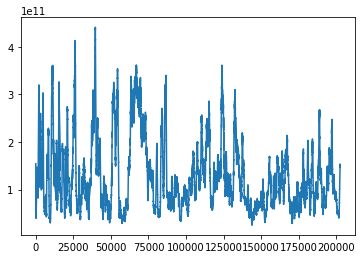

In [7]:
avgs = ma(elbos, window)
sns.lineplot(x = range(len(avgs)), y = avgs)

In [8]:
from pyro.infer import Predictive

predictive = Predictive(sample_model, guide=sample_guide, num_samples=1000, return_sites=("latent_f",))
node_idx = 10
subset, edge_index_adj, mapping, edge_mask_hard = k_hop_subgraph(
            node_idx, k, edge_index, relabel_nodes=True)
samples = predictive(x[subset, :], preds[node_idx, :], edge_index_adj, node_idx, mapping[0])

Loss -> 8477112832.0000: 100%|██████████| 203100/203100 [33:30<00:00, 112.04it/s]

In [9]:
samples['latent_f'].mean(dim=0)

tensor([0.6932, 0.6968, 0.7060, 0.7213, 0.6985, 0.6809, 0.7260, 0.7233, 0.6734,
        0.7003, 0.6999, 0.7129], grad_fn=<MeanBackward1>)